In [1]:
import os 
import sys
sys.path.append('..')
import numpy as np
import pandas as pd
import networkx as nx 
from copy import deepcopy as dc
import matplotlib.pyplot as plt
import network_analysis as nta
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

tlevel = 'g'
net_path = '../data/plasmid_network_{}.tsv'.format(tlevel)
taxonomy_path = '../data/taxonomy_df.tsv'
outdir = '../result/S1_plasmid_net/feature'
if not os.path.exists(outdir):
    os.makedirs(outdir)

data = pd.read_csv(net_path, sep='\t', header=0, index_col=0)
np.fill_diagonal(data.values, 0)
# drop index == g__
data.drop(index='g__', columns='g__', inplace=True)


In [2]:
sum_df = data.sum()
sp_list = sum_df[sum_df > 0].index.tolist()
data = data.loc[sp_list, sp_list]
print('shape of {} level is: {}'.format(tlevel, data.shape))
taxonomy_df = pd.read_csv(taxonomy_path, sep='\t', header=0, index_col=0)
data.to_csv(os.path.join(outdir, 'count_net.tsv'), sep='\t') 


shape of g level is: (787, 787)


In [3]:
# normalized by degree
undirected = dc(data)
col_sum = np.sqrt(undirected.sum())
undirected = undirected.div(col_sum, axis=1)
undirected = undirected.div(col_sum, axis=0)
undirected.to_csv(os.path.join(outdir, 'degree_norm.tsv'), sep='\t') 

graph = undirected
binary = dc(graph)
binary[binary>0] = 1


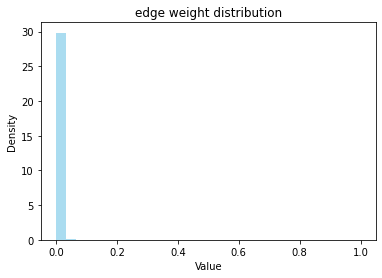

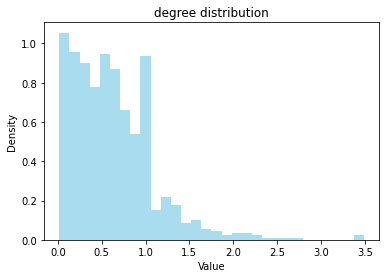

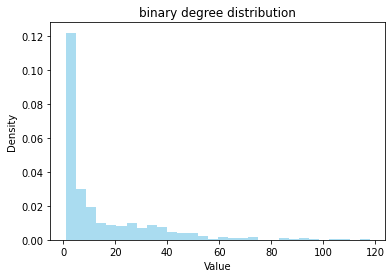

In [4]:
nta.distribution(graph.values.flatten(), 'edge weight distribution')
nta.distribution(graph.sum(), 'degree distribution')
nta.distribution(binary.sum(), 'binary degree distribution')

pe = 9.238623148278009
dict_values([0.0011691337815055239, 0.00028568311029111436, 0.0015222096764929964, 0.0013980267608695563, 0.00115391301011093, 0.002123374209864967, 0.0012994928067804343, 0.0013062318330951308, 0.0019669896861564612, 0.0021939518073401136, 0.0042994239324374, 0.002516057235197752, 0.0007809317741208049, 0.004445345245321692, 0.002495784721502803, 0.00477932866915919, 0.002560806660011202, 0.0047130618749927095, 0.004584944208223752, 0.0012706480304955528, 0.001955933728618695, 0.004122384662238687, 0.0031743269784361306, 0.0023012620608394312, 0.0010646809871179535, 0.001482967356786995, 0.0008311031630739674, 0.0005404826919601782, 0.0008109281498868749, 0.0007824990092464183, 0.00041519955301635883, 0.001583220983432341, 0.003683958193912289, 0.0019813789182404696, 0.002084118264000676, 0.0002613593499886579, 0.0003429866943074567, 0.000980474665026377, 0.003619361060599771, 0.0033395051334785576, 0.0014766270138599892, 0.0013240644836737426, 0.000678803768944

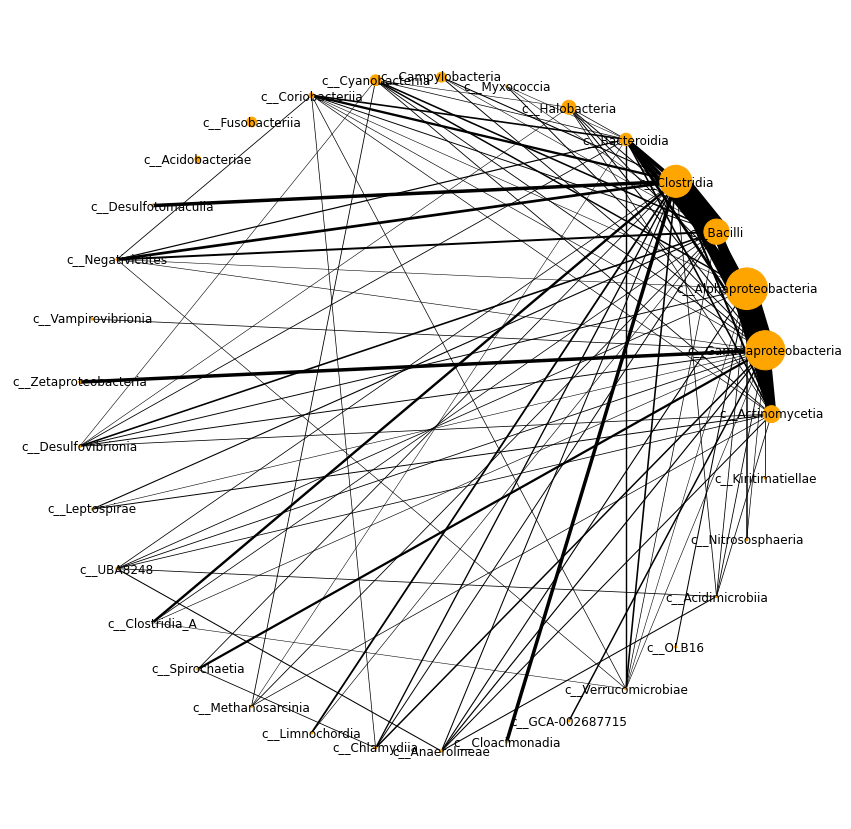

In [5]:
pe = nta.pe(graph)
print("pe = {}".format(pe))
pr_df, pr = nta.pr(graph)
pr_df.to_csv(os.path.join(outdir, 'pagerank.tsv'), sep='\t', header=True, index=True)
print("largest pr = {}".format(pr))
btw = nta.betweenness(graph)
btw.to_csv(os.path.join(outdir, 'betweeness.tsv'), sep='\t', header=True, index=True)
density = nta.density(graph)
print("density = {}".format(density))

print(nta.density(binary))
cc = nta.clustering_coef(graph)
print('node connect coef = {}'.format(cc[0]))
cc[1].to_csv(os.path.join(outdir, 'node_connect_coef.tsv'), sep='\t', header=True, index=True)

connected, ncomponent, component_dict  = nta.connected_component(graph)
print("network connected = {}, component num = {}, size={}".format(connected, ncomponent, [len(c) for c in component_dict.values()]))
with open(os.path.join(outdir, 'connected_component.tsv'), 'w') as fp:
    s = ''
    for c in component_dict.values():
        s += ','.join(c) + '\n'
    fp.write(s)


taxonomy_df_select = taxonomy_df[['g', 'c']]
taxonomy_df_select = taxonomy_df_select.drop_duplicates()
taxonomy_df_select = taxonomy_df_select.set_index('g')
intra_df, inter_df = nta.inter_intra('c', taxonomy_df_select, graph, normalized=False)
intra_df.to_csv(os.path.join(outdir, "intra_{}.tsv".format('c')), sep='\t')    
inter_df.to_csv(os.path.join(outdir, "inter_{}.tsv".format('c')), sep='\t')    
plt.figure(figsize=(15, 15))
class_list = list(inter_df.index)
sizes = list(intra_df.loc[class_list, 'edge_n']*30 + 5)
#print(inter_df)
G = nx.from_numpy_array(inter_df.values)
#print(G.edges)
edge_widths = [inter_df.values[u][v]*3+0.5 for u, v in G.edges()]
pos = nx.circular_layout(G) 
labels = {node: class_list[node] for node in G.nodes()}  
nx.draw_networkx_labels(G, pos, labels, font_size=12, font_color='black')
#nx.draw(G, pos, with_labels=False, node_size=sizes, width=edge_widths)
nx.draw(G, pos, node_size=sizes, width=edge_widths, node_color='orange')
plt.savefig(os.path.join(outdir, 'taxonomy_cluster_net.pdf'), format='pdf')
plt.show()

In [6]:
class_df = taxonomy_df[['g', 'd']].drop_duplicates()
class_df = class_df.set_index('g')
class_list = []
for g in graph.index:
    c = class_df.loc[g, 'd']
    class_list.append(c)
from collections import Counter
count = Counter(class_list)
print(count)

Counter({'d__Bacteria': 769, 'd__Archaea': 18})


In [7]:
count = (graph > 0.1).sum().sum()
count/(graph > 0).sum().sum()

0.07529746048659208

In [8]:
tmp_n = 0
class_df = taxonomy_df[['g', 'c']].drop_duplicates()
class_df = class_df.set_index('g')
for tmp_components in component_dict.values():
    clist = []
    for c in tmp_components:
        clist.append(class_df.loc[c, 'c'])
    count = Counter(clist)
    ratio = [v/len(tmp_components) for v in count.values()]
    print(count, ratio)
    if len(count) == 1:
        print('single class component')
        tmp_n += 1
print(tmp_n)

Counter({'c__Alphaproteobacteria': 192, 'c__Gammaproteobacteria': 191, 'c__Clostridia': 132, 'c__Bacilli': 89, 'c__Actinomycetia': 46, 'c__Bacteroidia': 20, 'c__Halobacteria': 16, 'c__Cyanobacteriia': 13, 'c__Campylobacteria': 6, 'c__Coriobacteriia': 5, 'c__Negativicutes': 4, 'c__Desulfovibrionia': 3, 'c__Spirochaetia': 2, 'c__Anaerolineae': 2, 'c__Chlamydiia': 1, 'c__Nitrososphaeria': 1, 'c__Kiritimatiellae': 1, 'c__Verrucomicrobiae': 1, 'c__Clostridia_A': 1, 'c__GCA-002687715': 1, 'c__UBA8248': 1, 'c__Vampirovibrionia': 1, 'c__Acidimicrobiia': 1, 'c__Methanosarcinia': 1, 'c__Limnochordia': 1, 'c__Leptospirae': 1, 'c__Myxococcia': 1, 'c__OLB16': 1}) [0.17959183673469387, 0.2612244897959184, 0.12108843537414966, 0.2598639455782313, 0.0013605442176870747, 0.0013605442176870747, 0.027210884353741496, 0.021768707482993196, 0.017687074829931974, 0.06258503401360545, 0.006802721088435374, 0.00816326530612245, 0.0027210884353741495, 0.005442176870748299, 0.004081632653061225, 0.0013605442176

In [9]:
edge_values = graph.values.flatten()
len(edge_values[edge_values>0])/2

5631.0

In [10]:
degree = binary.sum()
class_degree = pd.Series()
for idx in degree.index:
    if idx in class_df.index:
        c = class_df.loc[idx, 'c']
        if c not in class_degree:
            class_degree[c] = 0
        class_degree[c] += degree[idx]
class_degree.sort_values(ascending=False, inplace=True)

<ipython-input-10-8731c23f8a5a>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  class_degree = pd.Series()


In [11]:
class_degree

c__Gammaproteobacteria    3468
c__Clostridia             3041
c__Alphaproteobacteria    2189
c__Bacilli                1287
c__Bacteroidia             371
c__Actinomycetia           360
c__Coriobacteriia           89
c__Halobacteria             82
c__Cyanobacteriia           67
c__Negativicutes            61
c__Verrucomicrobiae         49
c__Desulfovibrionia         38
c__Clostridia_A             29
c__Campylobacteria          27
c__Anaerolineae             20
c__Chlamydiia               16
c__Acidimicrobiia           10
c__UBA8248                  10
c__Myxococcia                9
c__Fusobacteriia             6
c__Spirochaetia              6
c__Methanosarcinia           6
c__Limnochordia              6
c__Leptospirae               4
c__Nitrososphaeria           2
c__Acidobacteriae            2
c__OLB16                     1
c__Zetaproteobacteria        1
c__GCA-002687715             1
c__Cloacimonadia             1
c__Vampirovibrionia          1
c__Desulfotomaculia          1
c__Kirit

In [19]:
degree.sort_values(ascending=False, inplace=True)
degree

g__Salmonella         118.0
g__Pseudomonas_E      110.0
g__Blautia_A          109.0
g__Klebsiella         106.0
g__Enterocloster       95.0
                      ...  
g__Roseateles_A         1.0
g__Caprobacter          1.0
g__Pelotomaculum_C      1.0
g__Frankia              1.0
g__Eubacterium_B        1.0
Length: 787, dtype: float64

In [13]:
tmp = cc[1]
tmp[tmp==1]

,coef
g__Nocardioides,1.0
g__Ventosimonas,1.0
g__Colwellia,1.0
g__Amedibacillus,1.0
g__Wohlfahrtiimonas,1.0
...,...
g__Chitinibacter,NaN
g__Massiliomicrobiota,NaN
g__Albimonas,NaN
g__Aeromicrobium,NaN


In [14]:
class_df.loc['g__Salmonella', 'c']

'c__Gammaproteobacteria'

In [15]:
735/len(graph)

0.9339263024142312

In [18]:
tmp_n=0
for c, v in component_dict.items():
    if len(v) == 2:
        print(c,v)
        tmp_n += 1
tmp_n

1 ['g__Chryseobacterium', 'g__Epilithonimonas']
3 ['g__Leptotrichia', 'g__JABCPH02']
4 ['g__Duganella', 'g__Polaromonas']
5 ['g__Edaphobacter', 'g__Acidipila']
6 ['g__Lutispora', 'g__Pelotomaculum_C']
8 ['g__Helicobacter_E', 'g__Helicobacter']
9 ['g__Phycicoccus_A', 'g__Tetrasphaera_A']
10 ['g__Methylocystis', 'g__Methylosinus']
11 ['g__Hamiltonella', 'g__Regiella']
12 ['g__GCA-2401635', 'g__Gallionella']
14 ['g__Gordonia', 'g__Tsukamurella']
15 ['g__Leptotrichia_A', 'g__Fusobacterium']
16 ['g__Cohnella', 'g__Paenibacillus_I']
17 ['g__Fusobacterium_A', 'g__Cetobacterium']
18 ['g__WG-1', 'g__Ruminobacter']
19 ['g__Pontibacter', 'g__Amaricoccus']
20 ['g__JAAYML01', 'g__UBA4175']
21 ['g__Oligella', 'g__Advenella']
22 ['g__UBA11524', 'g__Pseudomonas_D']
23 ['g__Clostridium_F', 'g__Caprobacter']
24 ['g__Keratinibaculum', 'g__Vespertiliibacter']


21